In [9]:
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from tqdm import tqdm
from scipy.stats import zscore

root = "C://Users//Josh Selfe//OneDrive - Nexus365//Other Documents//Neuromatch"

sup_bef = 'VR2_2021_03_20_1' #example mouse before supervised learning
sup_aft = 'VR2_2021_04_06_1' #example mouse after supervised learning
unsup_bef = 'TX105_2022_10_08_2' #example mouse before supervised learning
unsup_aft = 'TX105_2022_10_19_2' #example mouse after supervised learning

In [ ]:
Beh_unsup_after = np.load(os.path.join(root, 'Beh_unsup_train1_after_learning.npy'), allow_pickle=1).item()
unsup_aft = "TX105_2022_10_19_2"
beh = Beh_unsup_after [unsup_aft]

stim_id = beh['stim_id'] # 0:circle1, 1:circle2, 2:leaf1, 3:leaf2, 4:leaf3
ntrials, uniqW, WallN = beh['ntrials'], beh['UniqWalls'], beh['WallName']#WallN is stim type for each trial
SoundPos = beh['SoundPos']

#lick_fr = beh['LickFr'] # frame with lick
#cue_fr = beh['SoundFr'] # frame with cue
stim_fr = beh['ft_WallID'] # trial stimulus of each frame
pos_fr = beh['ft_Pos'] # position of each frame inside corridor
cum_pos_fr = beh['ft_PosCum']
VR_move = beh['ft_move']>0 # frames with virtual scene moving

name_stim1 = uniqW[stim_id==2][0] # name of stimulus 1; rewarded stimulus (leaf1) for supervised experiment
name_stim2 = uniqW[stim_id==0][0] # name of stimulus 2; non-rewarded stimulus (circle1) for supervised experiment
stim1_tr = WallN==name_stim1 #trials with leaf
stim2_tr = WallN==name_stim2 # trials with circle

# get index of frame within stimulus 1 (0-40 is within texture area, 40-60 is gray space)
stim1_idx = (stim_fr==name_stim1) & (pos_fr<40)
stim2_idx = (stim_fr==name_stim2) & (pos_fr<40)
gray_idx = ((stim_fr==name_stim1) | (stim_fr==name_stim2)) & (pos_fr>=40)

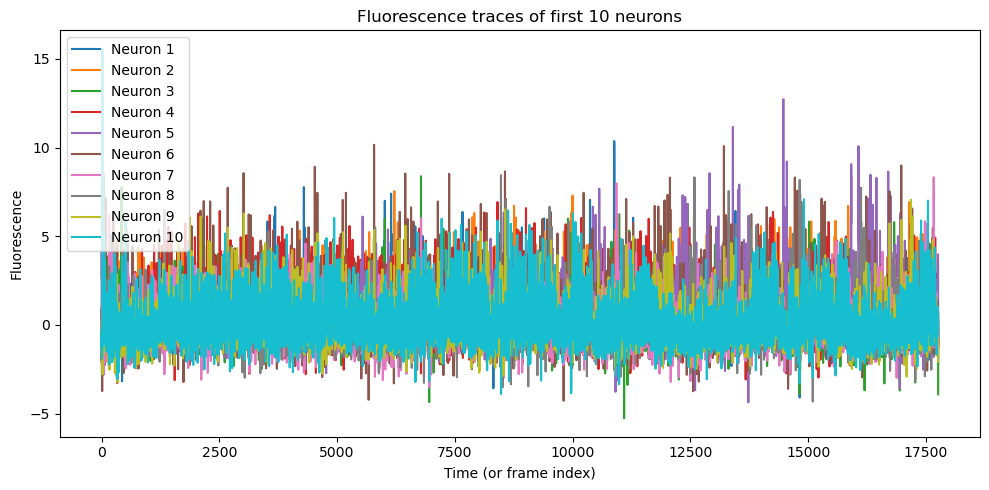

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(spks[i], label=f'Neuron {i+1}')

plt.xlabel("Time (or frame index)")
plt.ylabel("Fluorescence")
plt.title("Fluorescence traces of first 10 neurons")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
svd_dec_400pc = np.load(os.path.join(root, sup_aft +'_SVD_dec.npy'), allow_pickle=1).item() # 400 PCs
spks = svd_dec_400pc['U'][:, :].T @ svd_dec_400pc['V'] # project from the PC space back to neural space (only do it for the first 1000 neuorns)
spks = zscore(spks, axis=1)
nfrs = spks.shape[1]
subset = spks[:1000, :]

c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
model = Rastermap(n_clusters=100, # number of clusters to compute
                  n_PCs=128, # number of PCs to use
                  locality=0.75, # locality in sorting to find sequences (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                ).fit(spks)
y = model.embedding # neurons x 1
isort = model.isort

2025-07-16 16:57:08,383 [INFO] normalizing data across axis=1


2025-07-16 16:57:51,279 [INFO] projecting out mean along axis=0
2025-07-16 16:58:15,636 [INFO] data normalized, 67.26sec
2025-07-16 16:58:15,702 [INFO] sorting activity: 71069 valid samples by 17760 timepoints
2025-07-16 16:59:56,431 [INFO] n_PCs = 128 computed, 168.06sec
2025-07-16 17:00:27,785 [INFO] 100 clusters computed, time 199.42sec
2025-07-16 17:00:39,971 [INFO] clusters sorted, time 211.60sec
2025-07-16 17:00:41,192 [INFO] clusters upsampled, time 212.82sec
2025-07-16 17:00:44,754 [INFO] rastermap complete, time 216.39sec


In [10]:
nbin = 200 # number of neurons to bin over
sn = utils.bin1d(spks[isort], bin_size=nbin, axis=0) # bin over neuron axis

In [ ]:
import dash
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from dash import callback, dcc, html, State

matrix = sn
NN, NT = matrix.shape

# get indices of neurons corresponding to each superneuron
NN_all = spks.shape[0]
indices_bin = isort[:NN_all // nbin * nbin].reshape((NN_all // nbin, nbin))

# decide how many time points to show per frame
NT_show = min(1000, NT-1)
nmin, nmax = 0, NN
tmin, tmax = 0, NT_show

# swap the xpos and ypos
xpos_plot = ypos
ypos_plot = xpos

# visualize first frame
fig = go.Figure(
    data=[
        go.Heatmap(
            x=np.arange(tmin, tmax).tolist(),
            z=matrix[:, tmin:tmax],
            colorscale="Greys",
            zmin=0,
            zmax=0.8,
        )
    ]
)

# initialize the positions of the selecting bar
x0 = tmin
x1 = tmin+NT_show
y0 = nmin+int(NN/10) * 8
y1 = nmin+int(NN/10) * 9

# visualize neurons with their positions
color_values = np.ones(len(xpos_plot)) * 0.1
size_values = np.ones(len(xpos_plot)) * 5

neuron_fig = go.Figure(
    data=[
        go.Scattergl(x=xpos_plot, y=ypos_plot, mode='markers',
                    marker=dict(
                  size=size_values,
                  color=color_values,
                  colorscale='Purples',
                  cmin=0,
                  cmax=1,
                  )
                  )
    ]
)

neuron_fig.update_layout(
    width=500,
    height=500,
    yaxis={"title": 'y position'},
    xaxis={"title": 'x position'},
    template='simple_white',
    margin=dict(l=10, r=0, t=100, b=0),
)

# define the dash app layout
app = dash.Dash(__name__)
app.layout = html.Div(
    style={'display': 'flex', 'flex-direction': 'row', "padding": "0", "margin": "0"},
    children=[
        html.Div(
            style={"width": "60%", "display": "flex", "flex-direction": "column", "padding": "0", "margin": "0"},
            children=[
                html.Div(
                    style={'display': 'flex', 'flex-direction': 'row', "padding": "10", "margin": "10"},
                    children=[
                        html.H2("Rastermap", style={'margin': '0'}),
                        html.Div(dcc.Input(id='input-on-submit', type='text', placeholder="{}".format(NT_show)), style={'margin-left': '10px', 'margin-top': '50px'}),
                        html.Button('Submit', id='submit-val', n_clicks=0, style={'height': '20px', 'margin-left': '10px', 'margin-top': '50px'}),
                        html.Div(id='button-output', children=f'number of time points to show: {NT_show}',
                                 style = {'margin-left': '10px', 'margin-top': '50px'})
                    ]
                ),
                dcc.Graph(id="matrix-plot",
                          figure=fig,
                          config={
                              'edits': {
                                  'shapePosition': True
                              }
                          },
                          style={'margin-top': '0px'}
                          ),
                dcc.Slider(0, 1, step=1/NT, id='slider-time',
                           marks={i*NT/(NT-NT_show): '{}'.format(int(i*NT)) for i in (np.arange(NT+1, step=int(NT/10))/NT).tolist()})
            ]
        ),
        html.Div(
            style={"width": "40%", "display": "inline-block", "padding": "0", "margin": "0"},
            children=[
                html.H2("Neuron locations"),
                dcc.Graph(id="neuron-plot")
            ]
        )
    ]
)

# call back for slider to change time points to show
@app.callback(
    Output("matrix-plot", 'figure'),
    Input('slider-time', 'value'),
    )
def update_output(tvalue):
    if tvalue is not None:
        tmin = int((NT-NT_show)*tvalue)
        tmax = tmin + NT_show
    else:
        tmin, tmax = 0, NT_show

    fig = go.Figure(
        data=[
            go.Heatmap(
                x=np.arange(tmin, tmax).tolist(),
                z=matrix[:, tmin:tmax],
                colorscale="Greys",
                zmin=0,
                zmax=0.8,
            )
        ]
    )

    fig.add_shape(type="rect",
        xref="x", yref="y",
        x0=tmin, y0=y0,
        x1=tmin+x1-x0, y1=y1,
        line=dict(
            color="grey",
            width=3,
        ),
        fillcolor="grey",
        opacity=0.5,
        xanchor=tmin,
    )

    fig.update_layout(
        width=800,
        height=500,
        yaxis={"title": 'Neuron'},
        xaxis={"title": 'Time'},
        margin=dict(l=0, r=0, t=50, b=0),
    )
    return fig

# call back for moving the selecting bar to select neurons
@app.callback(
    Output("neuron-plot", "figure"),
    Input("matrix-plot", "relayoutData"))
def update_matrix_plot(relayout_data):
    global x0, y0, x1, y1
    color_values = np.ones(len(xpos_plot)) * 0.1
    size_values = np.ones(len(xpos_plot)) * 5
    if relayout_data is not None:
        x0, y0 = int(relayout_data["shapes[0].x0"]), int(relayout_data["shapes[0].y0"])
        x1, y1 = int(relayout_data["shapes[0].x1"]), int(relayout_data["shapes[0].y1"])
        neuron_range = np.arange(y0, y1)
        neuron_range = indices_bin[neuron_range].reshape(-1)
        color_values[neuron_range] = 1
        size_values[neuron_range] = 5

    neuron_fig['data'][0]['marker']['color'] = color_values
    neuron_fig['data'][0]['marker']['size'] = size_values

    return neuron_fig

# call back for updating number of time points to show per frame
@callback(
    Output('button-output', 'children'),
    Output('slider-time', 'marks'),
    Input('submit-val', 'n_clicks'),
    State('input-on-submit', 'value')
)
def update_timepoints_show(n_clicks, value):
    global NT_show, x1
    if value is not None:
        NT_show = int(value)
        x1 = x0+NT_show
    else:
        value = NT_show
    text_to_show = f'number of time points to show: {value}'
    new_marks = {i*NT/(NT-NT_show): '{}'.format(int(i*NT)) for i in (np.arange(NT+1, step=int(NT/10))/NT).tolist()}
    return text_to_show, new_marks

# run the app
app.run_server(jupyter_mode='inline')